In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Principal Component Analysis - для уменьшения размерности данных
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering # Алгоритмы кластеризации
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import os
from PIL import Image # Для картиночек
import warnings
warnings.filterwarnings('ignore')

# Для красивого отображения графиков
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)

In [15]:
def extract_features(image_path): # Извлечение признаков из фотки (средние RGB-каналы и их стандартные отклонения (типа текстура))
    try:
        with Image.open(image_path) as img:
            # Конвертация в RGB (на всякий)
            img = img.convert('RGB')
            
            # Всё в массив
            img_array = np.array(img)
            
            # Извлечение признаки цвета
            r_mean = np.mean(img_array[:, :, 0])
            g_mean = np.mean(img_array[:, :, 1])
            b_mean = np.mean(img_array[:, :, 2])
            
            r_std = np.std(img_array[:, :, 0])
            g_std = np.std(img_array[:, :, 1])
            b_std = np.std(img_array[:, :, 2])
            
            # Допом: соотношения цветов
            brightness = (r_mean + g_mean + b_mean) / 3
            r_g_ratio = r_mean / (g_mean + 1e-5)  # +1e-5 чтобы избежать деления на 0
            g_b_ratio = g_mean / (b_mean + 1e-5)
            
            return [r_mean, g_mean, b_mean, r_std, g_std, b_std, 
                    brightness, r_g_ratio, g_b_ratio]
    
    except Exception as e:
        print(f"Ошибка при обработке {image_path}: {e}")
        return None

def load_folio_dataset(data_path): # Загрузка Folio и извлечение признаков
    features = [] # Вектора признаков
    filenames = [] # Имена файлов
    class_labels = [] # Метки классов (т.е. названия папок)
    
    # Прохожу по всем папкам-классам
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        
        if os.path.isdir(class_path): # Проверка: папка?
            for img_file in os.listdir(class_path): # Перебор файлов в папке
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')): # Проверка расширений в конце
                    img_path = os.path.join(class_path, img_file)
                    feature_vector = extract_features(img_path) # Извлечение признаков
                    
                    if feature_vector is not None: # И вводим, если признаки есть (а как иначе)
                        features.append(feature_vector)
                        filenames.append(img_file)
                        class_labels.append(class_name)
    
    # Создание DF
    feature_names = ['r_mean', 'g_mean', 'b_mean', 'r_std', 'g_std', 'b_std', 
                     'brightness', 'r_g_ratio', 'g_b_ratio']
    
    df = pd.DataFrame(features, columns=feature_names)
    df['filename'] = filenames
    df['class'] = class_labels
    
    return df

data_path = 'C:/Users/Roman/Folio'
folio_df = load_folio_dataset(data_path)

# Проверка структуры данных (отладка)
print(f"Размерность данных: {folio_df.shape}")
print("\nПервые 5 строк:")
print(folio_df.head())
print("\nИнформация о данных:")
print(folio_df.info())

Размерность данных: (637, 11)

Первые 5 строк:
       r_mean      g_mean      b_mean      r_std      g_std       b_std  \
0  165.891528  176.601300  143.410146  75.109999  62.930738   98.094912   
1  161.990849  168.028723  145.023171  75.736429  66.417260   94.336935   
2  163.543315  172.788652  140.725359  79.311071  68.231762  103.590441   
3  167.161670  174.863194  142.841619  71.754916  61.876461   98.925472   
4  163.413101  173.226582  140.785941  78.601877  67.427913  101.124048   

   brightness  r_g_ratio  g_b_ratio             filename          class  
0  161.967658   0.939356   1.231442  20150324_153259.jpg  ashanti blood  
1  158.347581   0.964066   1.158634  20150324_153314.jpg  ashanti blood  
2  159.019109   0.946493   1.227843  20150324_153329.jpg  ashanti blood  
3  161.622161   0.955957   1.224175  20150324_153348.jpg  ashanti blood  
4  159.141875   0.943349   1.230425  20150324_153401.jpg  ashanti blood  

Информация о данных:
<class 'pandas.core.frame.DataFrame'

In [16]:
# Отделение признаков от меток и имен файлов
X = folio_df.drop(['filename', 'class'], axis=1) # Столбцы с именем и папкой до свидания, axis=1 => УДАЛЯЕМ СТОЛБЦЫ, НЕ СТРОКИ
true_labels = folio_df['class'] # Сохранение меток класса (то есть названий)
filenames = folio_df['filename'] # Сохранение filename для отслеживания, к какому изображению результаты относятся

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Данные после масштабирования:")
print(f"Размерность: {X_scaled.shape}")
print(f"Средние значения: {np.mean(X_scaled, axis=0)}")
print(f"Стандартные отклонения: {np.std(X_scaled, axis=0)}")

Данные после масштабирования:
Размерность: (637, 9)
Средние значения: [-7.80816193e-16  9.81597500e-16  8.92361364e-17  3.40212770e-16
  1.27161494e-15  3.79253580e-16  6.02343920e-16 -5.71111273e-15
  2.18628534e-15]
Стандартные отклонения: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


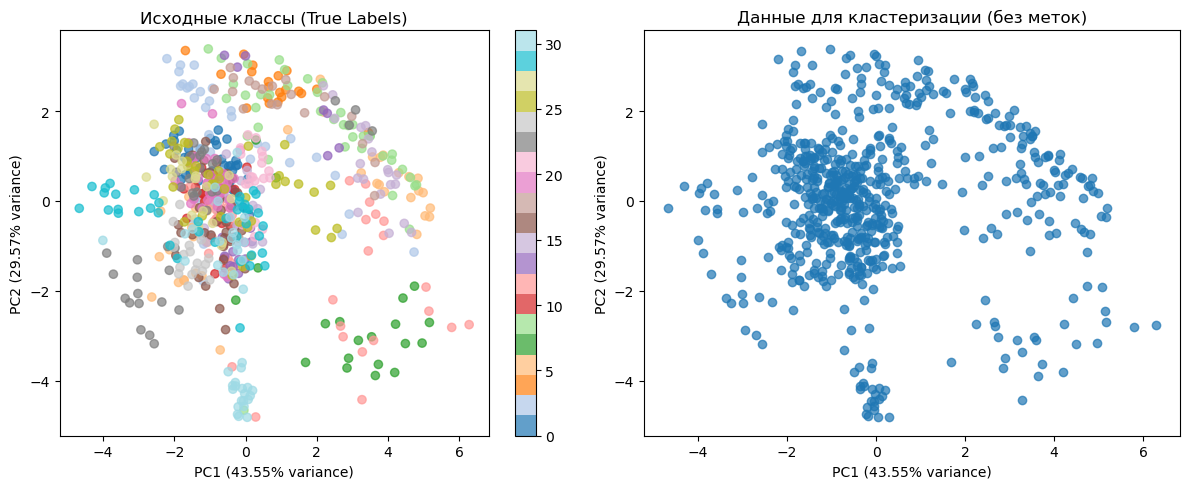

Объясненная дисперсия PCA: 73.13%
Состав PC1 и PC2:
                 PC1       PC2
r_mean      0.489250  0.026668
g_mean      0.478577  0.100639
b_mean      0.490576  0.033929
r_std      -0.007965  0.573448
g_std      -0.025683  0.492903
b_std      -0.082860  0.547873
brightness  0.500968  0.055003
r_g_ratio   0.077195 -0.316687
g_b_ratio  -0.162534  0.112840


In [17]:
pca = PCA(n_components=2) # Применение PCA для визуализации в 2D
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # Визуализация исходных классов (для reference)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(true_labels)[0], 
                     cmap='tab20', alpha=0.7)
plt.title('Исходные классы (True Labels)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter)

plt.subplot(1, 2, 2) # Визуализация без цветов (как видит алгоритм кластеризации)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.title('Данные для кластеризации (без меток)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

plt.tight_layout()
plt.show()

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum():.2%}")

# смотрю, из чего состоят главные компоненты (отладка)
print("Состав PC1 и PC2:")
components_df = pd.DataFrame(
    pca.components_.T,  # транспонируется матрица компонент
    columns=['PC1', 'PC2'],
    index=X.columns      # названия исходных признаков
)
print(components_df)

Оптимальное число кластеров по silhouette score: 2


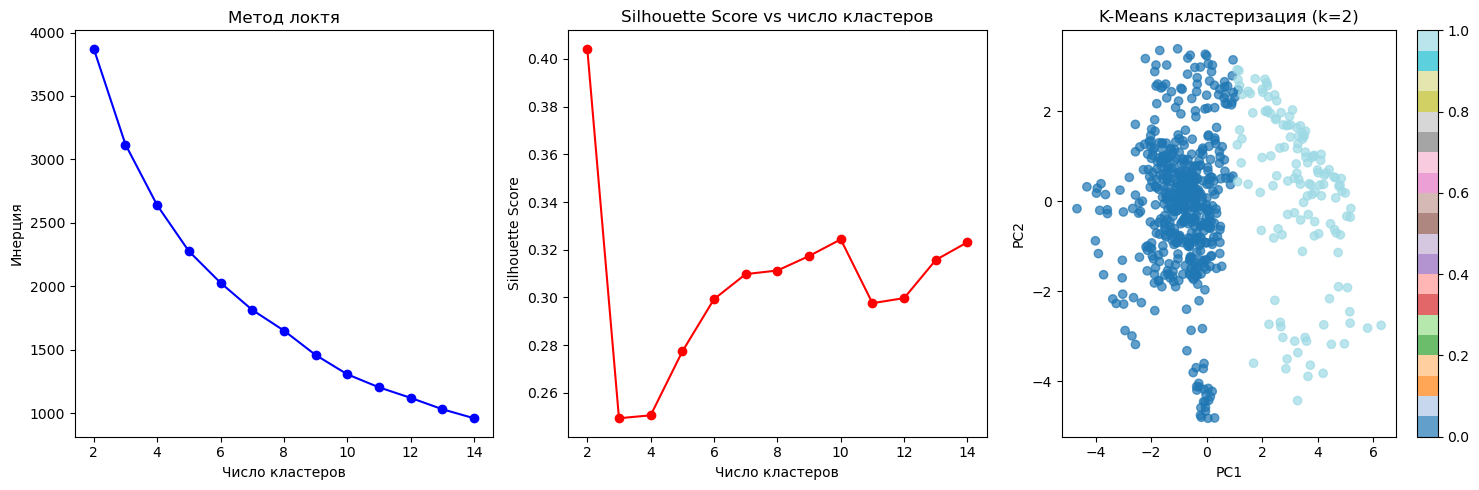

K-Means Results (k=2):
Silhouette Score: 0.404
Calinski-Harabasz Score: 305.290


In [31]:
# Подбор оптимального числа кластеров для K-Means
inertia = [] # Стоимость кластеризации - чем меньше - тем лучше. (сумма квадратов расстояний от точек до центров их кластеров)
silhouette_scores = [] # Качество кластеризации. больше - лучше. (Насколько хорошо точки внутри кластера похожи друг на друга и не похожи на точки из других кластеров.)
k_range = range(2, 15) # Проба k от 2 до 14 кластеров.

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# График локтя и silhouette score
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, inertia, 'bo-') # Ищу точку "излома", где инерция перестёт сильно уменьшаться
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя')

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-') # Максимальное значение - лучшее качество кластеризации
plt.xlabel('Число кластеров')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs число кластеров')

# Выбираю оптимальное k (например, где silhouette score максимален)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Оптимальное число кластеров по silhouette score: {optimal_k}")

# Кластеризация с оптимальным k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(X_scaled)

# Визуализация результатов K-Means
plt.subplot(1, 3, 3)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab20', alpha=0.7)
plt.title(f'K-Means кластеризация (k={optimal_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

# Оценка качества K-Means
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_scaled, kmeans_labels) # отношение "междукластерной дисперсии" к "внутрикластерной", кароч, чем больше, тем лучше

print(f"K-Means Results (k={optimal_k}):")
print(f"Silhouette Score: {kmeans_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {kmeans_calinski:.3f}")

Лучшие параметры DBSCAN:
eps              1.000000
min_samples     10.000000
n_clusters       2.000000
n_noise        167.000000
silhouette       0.219522
Name: 7, dtype: float64

Результаты DBSCAN:
Число кластеров: 2.0
Число точек шума: 167.0
Silhouette Score: 0.220
Calinski-Harabasz Score: 40.541


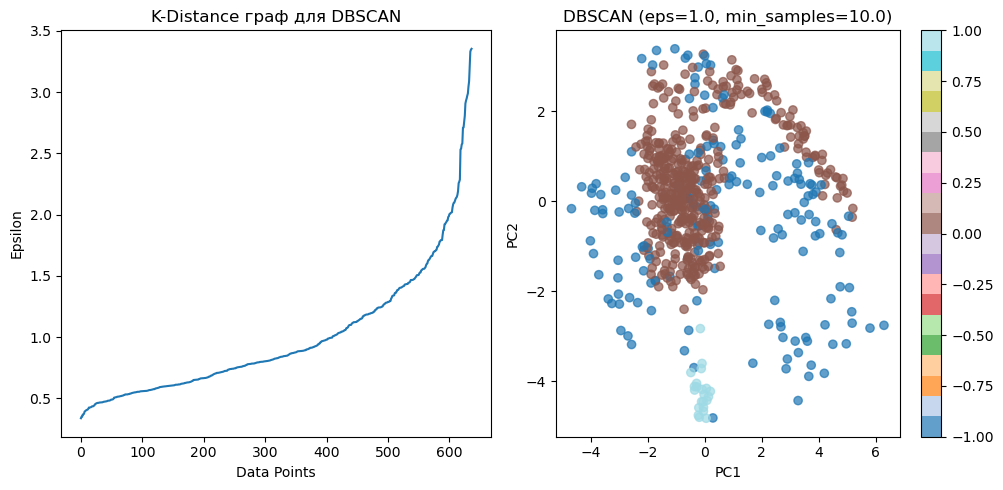

In [48]:
# Подбор параметров для DBSCAN
from sklearn.neighbors import NearestNeighbors

# Метод для подбора eps
neighbors = NearestNeighbors(n_neighbors=min(10, len(X_scaled)-1))
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('Epsilon')
plt.title('K-Distance граф для DBSCAN')

# Эксперименты с разными параметрами
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_values = [3, 5, 7, 10]

dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        
        # Пропускаем случаи, когда все точки в одном кластере или много шума
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        if n_clusters > 1 and n_clusters < len(X_scaled) // 2:
            silhouette = silhouette_score(X_scaled, dbscan_labels)
            dbscan_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': silhouette
            })

# DataFrame с результатами
dbscan_df = pd.DataFrame(dbscan_results)
if not dbscan_df.empty:
    best_dbscan = dbscan_df.loc[dbscan_df['silhouette'].idxmax()]
    
    print("Лучшие параметры DBSCAN:")
    print(best_dbscan)
    
    # Применение DBSCAN с лучшими параметрами
    dbscan_optimal = DBSCAN(eps=best_dbscan['eps'], 
                           min_samples=int(best_dbscan['min_samples']))
    dbscan_labels = dbscan_optimal.fit_predict(X_scaled)
    
    # Визуализация DBSCAN
    plt.subplot(1, 3, 2)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab20', alpha=0.7)
    plt.title(f'DBSCAN (eps={best_dbscan["eps"]}, min_samples={best_dbscan["min_samples"]})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter)
    
    # Оценка качества DBSCAN
    dbscan_silhouette = best_dbscan['silhouette']
    if len(set(dbscan_labels)) > 1:  # Calinski-Harabasz требует хотя бы 2 кластера
        dbscan_calinski = calinski_harabasz_score(X_scaled, dbscan_labels)
    else:
        dbscan_calinski = 0
    
    print(f"\nРезультаты DBSCAN:")
    print(f"Число кластеров: {best_dbscan['n_clusters']}")
    print(f"Число точек шума: {best_dbscan['n_noise']}")
    print(f"Silhouette Score: {dbscan_silhouette:.3f}")
    print(f"Calinski-Harabasz Score: {dbscan_calinski:.3f}")
else:
    print("DBSCAN не смог найти хорошие кластеры с данными параметрами")
    dbscan_labels = np.zeros(len(X_scaled))  # Заглушка для продолжения работы
    dbscan_silhouette = 0
    dbscan_calinski = 0

plt.tight_layout()
plt.show()

In [38]:
# Анализ что такое Кластер 0 и Кластер 1
dbscan_cluster_0 = X_scaled[dbscan_labels == 0]  # все листья кластера 0
dbscan_cluster_1 = X_scaled[dbscan_labels == 1]  # все листья кластера 1
dbscan_noise = X_scaled[dbscan_labels == -1]     # шум

# Сравним средние значения признаков
print("СРЕДНИЕ ЗНАЧЕНИЯ ПРИЗНАКОВ ПО КЛАСТЕРАМ:")
print("=" * 50)

features = ['r_mean', 'g_mean', 'b_mean', 'brightness', 'r_std']

for feature in features:
    # Находим индекс признака в наших данных
    feature_idx = list(X.columns).index(feature)
    
    mean_0 = np.mean(dbscan_cluster_0[:, feature_idx])
    mean_1 = np.mean(dbscan_cluster_1[:, feature_idx])
    mean_noise = np.mean(dbscan_noise[:, feature_idx])
    
    print(f"{feature:12} | Кластер 0: {mean_0:6.2f} | Кластер 1: {mean_1:6.2f} | Шум: {mean_noise:6.2f}")

СРЕДНИЕ ЗНАЧЕНИЯ ПРИЗНАКОВ ПО КЛАСТЕРАМ:
r_mean       | Кластер 0:  -0.08 | Кластер 1:  -0.40 | Шум:   0.27
g_mean       | Кластер 0:  -0.08 | Кластер 1:  -0.62 | Шум:   0.31
b_mean       | Кластер 0:  -0.13 | Кластер 1:  -0.02 | Шум:   0.35
brightness   | Кластер 0:  -0.10 | Кластер 1:  -0.35 | Шум:   0.32
r_std        | Кластер 0:   0.26 | Кластер 1:  -2.03 | Шум:  -0.42


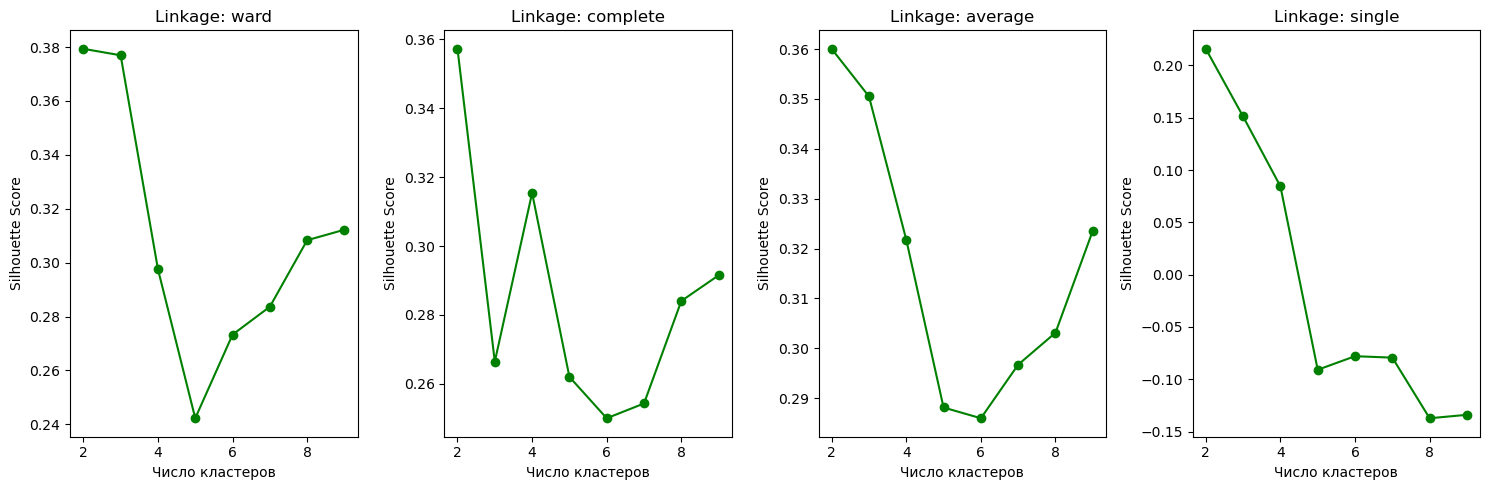

Лучшие параметры для Agglomerative Clustering:
linkage           ward
n_clusters           2
silhouette    0.379367
Name: 0, dtype: object


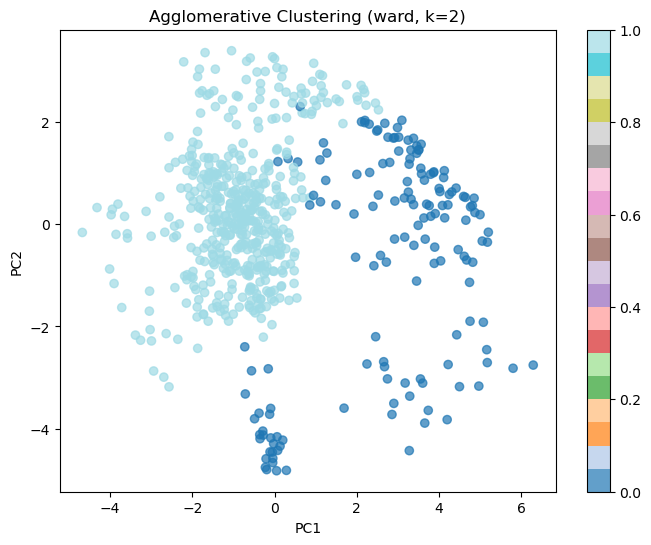


Agglomerative Clustering Results:
Silhouette Score: 0.379
Calinski-Harabasz Score: 250.956


In [47]:
# Эксперименты с Agglomerative Clustering
linkage_methods = ['ward', 'complete', 'average', 'single']
n_clusters_range = range(2, 10)

agg_results = []

plt.figure(figsize=(15, 5))

for i, linkage in enumerate(linkage_methods, 1):
    silhouette_scores_agg = []
    
    for n_clusters in n_clusters_range:
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        agg_labels = agg.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, agg_labels)
        silhouette_scores_agg.append(silhouette)
    
    # Находим оптимальное число кластеров для данного метода связи
    optimal_n_agg = n_clusters_range[np.argmax(silhouette_scores_agg)]
    best_silhouette = max(silhouette_scores_agg)
    
    agg_results.append({
        'linkage': linkage,
        'n_clusters': optimal_n_agg,
        'silhouette': best_silhouette
    })
    
    # Визуализация silhouette scores для каждого метода
    plt.subplot(1, 4, i)
    plt.plot(n_clusters_range, silhouette_scores_agg, 'go-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Silhouette Score')
    plt.title(f'Linkage: {linkage}')

plt.tight_layout()
plt.show()

# Выбираем лучший метод
agg_df = pd.DataFrame(agg_results)
best_agg = agg_df.loc[agg_df['silhouette'].idxmax()]

print("Лучшие параметры для Agglomerative Clustering:")
print(best_agg)

# Применяем иерархическую кластеризацию с лучшими параметрами
agg_optimal = AgglomerativeClustering(
    n_clusters=int(best_agg['n_clusters']), 
    linkage=best_agg['linkage']
)
agg_labels = agg_optimal.fit_predict(X_scaled)

# Визуализация дендрограммы (для методов кроме 'ward')
if best_agg['linkage'] != 'ward':
    from scipy.cluster.hierarchy import dendrogram, linkage
    
    plt.figure(figsize=(10, 6))
    # Берем подвыборку для лучшей визуализации
    if len(X_scaled) > 100:
        indices = np.random.choice(len(X_scaled), 100, replace=False)
        Z = linkage(X_scaled[indices], method=best_agg['linkage'])
    else:
        Z = linkage(X_scaled, method=best_agg['linkage'])
    
    dendrogram(Z)
    plt.title(f'Dendrogram (Linkage: {best_agg["linkage"]})')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

# Визуализация кластеров
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='tab20', alpha=0.7)
plt.title(f'Agglomerative Clustering ({best_agg["linkage"]}, k={best_agg["n_clusters"]})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter)
plt.show()

# Оценка качества Agglomerative Clustering
agg_silhouette = best_agg['silhouette']
agg_calinski = calinski_harabasz_score(X_scaled, agg_labels)

print(f"\nAgglomerative Clustering Results:")
print(f"Silhouette Score: {agg_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {agg_calinski:.3f}")

GAUSSIAN MIXTURE CLUSTERING
Оптимальное число компонент для GMM: 2


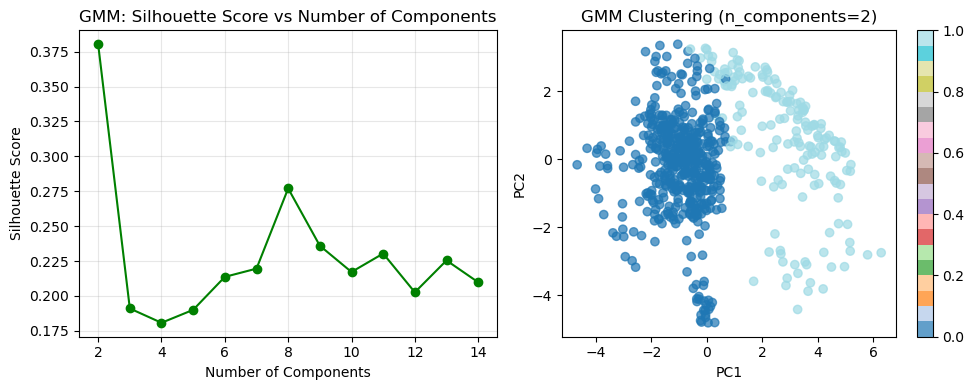

GMM Results (n_components=2):
Silhouette Score: 0.380
Calinski-Harabasz Score: 292.080
Распределение по кластерам GMM:
  Кластер 0: 473 листьев (74.3%)
  Кластер 1: 164 листьев (25.7%)


In [46]:
# Алгоритм 4: Gaussian Mixture Models
from sklearn.mixture import GaussianMixture

print("GAUSSIAN MIXTURE CLUSTERING")

# Подбор оптимального числа компонент для GMM
gmm_silhouette_scores = []
n_components_range = range(2, 15)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    
    if len(set(gmm_labels)) > 1:
        silhouette = silhouette_score(X_scaled, gmm_labels)
        gmm_silhouette_scores.append(silhouette)
    else:
        gmm_silhouette_scores.append(0)

# График подбора числа компонент
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, gmm_silhouette_scores, 'go-')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('GMM: Silhouette Score vs Number of Components')
plt.grid(True, alpha=0.3)

# Находим оптимальное число компонент
optimal_n_components = n_components_range[np.argmax(gmm_silhouette_scores)]
print(f"Оптимальное число компонент для GMM: {optimal_n_components}")

# Обучаем GMM с оптимальными параметрами
gmm_optimal = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm_labels = gmm_optimal.fit_predict(X_scaled)

# Визуализация результатов GMM
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='tab20', alpha=0.7)
plt.title(f'GMM Clustering (n_components={optimal_n_components})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

# Оценка качества GMM
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)
gmm_calinski = calinski_harabasz_score(X_scaled, gmm_labels)

print(f"GMM Results (n_components={optimal_n_components}):")
print(f"Silhouette Score: {gmm_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {gmm_calinski:.3f}")

# Анализ распределения кластеров
gmm_cluster_counts = pd.Series(gmm_labels).value_counts().sort_index()
print("Распределение по кластерам GMM:")
for cluster, count in gmm_cluster_counts.items():
    print(f"  Кластер {cluster}: {count} листьев ({count/len(gmm_labels)*100:.1f}%)")

СРАВНЕНИЕ 4 АЛГОРИТМОВ:
          Algorithm  Silhouette Score  Calinski-Harabasz Score  \
0           K-Means          0.404272               305.290372   
1            DBSCAN          0.219522                40.540931   
2     Agglomerative          0.379367               250.956406   
3  Gaussian Mixture          0.380294               292.080211   

                  Parameters  
0                        k=2  
1  eps=1.0, min_samples=10.0  
2          linkage=ward, k=2  
3             n_components=2  


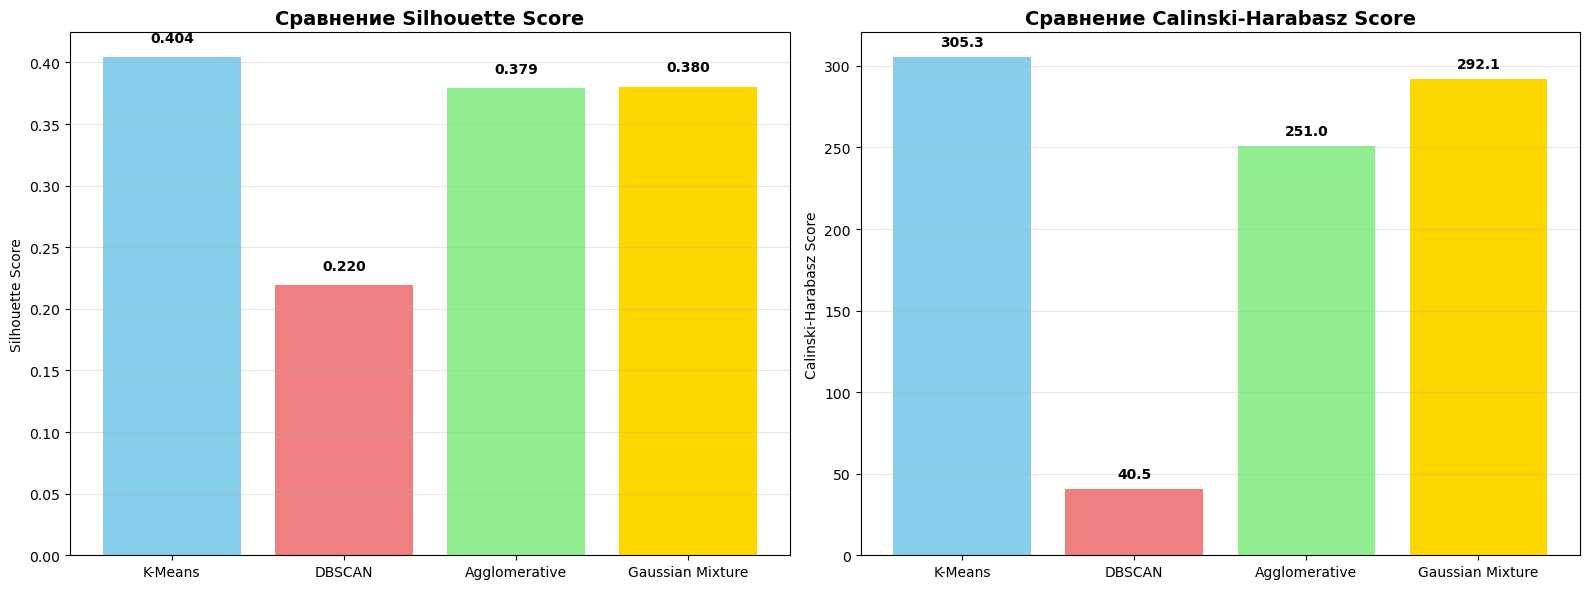

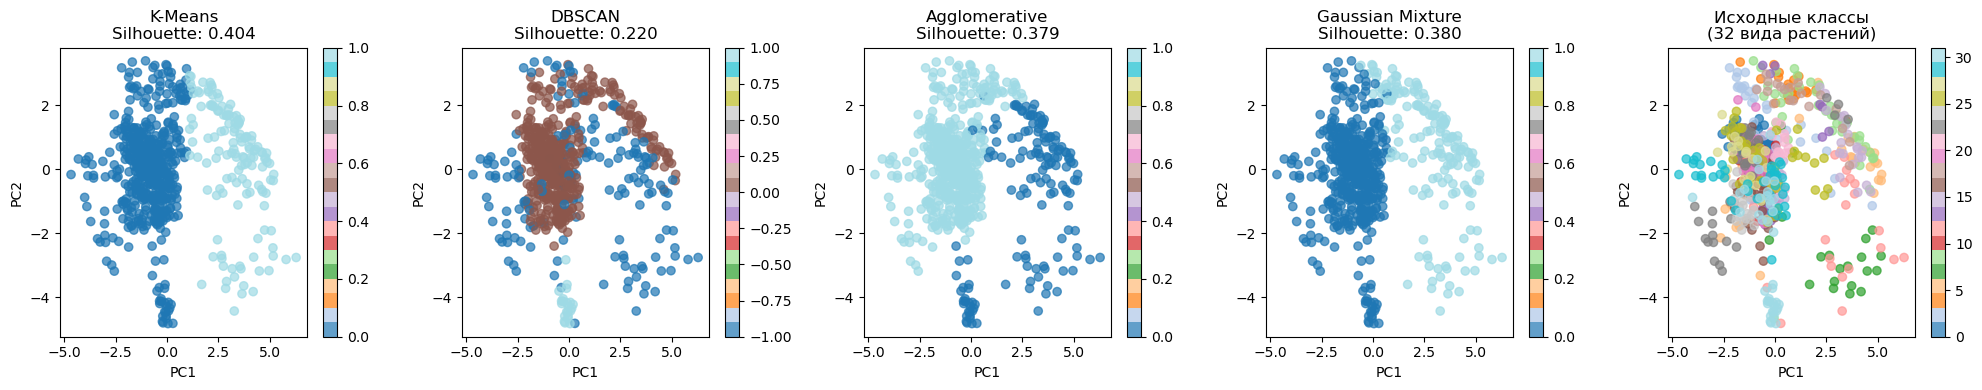

ЛУЧШИЙ АЛГОРИТМ: K-Means
Лучший Silhouette Score: 0.404


In [44]:
# Сводная таблица результатов для 4 алгоритмов
results_comparison = pd.DataFrame({
    'Algorithm': ['K-Means', 'DBSCAN', 'Agglomerative', 'Gaussian Mixture'],
    'Silhouette Score': [kmeans_silhouette, dbscan_silhouette, agg_silhouette, gmm_silhouette],
    'Calinski-Harabasz Score': [kmeans_calinski, dbscan_calinski, agg_calinski, gmm_calinski],
    'Parameters': [
        f'k={optimal_k}',
        f'eps={best_dbscan["eps"] if not dbscan_df.empty else "N/A"}, min_samples={best_dbscan["min_samples"] if not dbscan_df.empty else "N/A"}',
        f'linkage={best_agg["linkage"]}, k={best_agg["n_clusters"]}',
        f'n_components={optimal_n_components}'
    ]
})

print("СРАВНЕНИЕ 4 АЛГОРИТМОВ:")
print("=" * 60)
print(results_comparison)

# Визуализация сравнения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# График Silhouette Score
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
bars1 = ax1.bar(results_comparison['Algorithm'], results_comparison['Silhouette Score'], 
                color=colors)
ax1.set_title('Сравнение Silhouette Score', fontsize=14, fontweight='bold')
ax1.set_ylabel('Silhouette Score')
ax1.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar, score in zip(bars1, results_comparison['Silhouette Score']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# График Calinski-Harabasz Score
bars2 = ax2.bar(results_comparison['Algorithm'], results_comparison['Calinski-Harabasz Score'],
                color=colors)
ax2.set_title('Сравнение Calinski-Harabasz Score', fontsize=14, fontweight='bold')
ax2.set_ylabel('Calinski-Harabasz Score')
ax2.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar, score in zip(bars2, results_comparison['Calinski-Harabasz Score']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Визуализация всех результатов кластеризации (4 алгоритма + исходные классы)
plt.figure(figsize=(20, 4))

algorithms = [
    ('K-Means', kmeans_labels),
    ('DBSCAN', dbscan_labels),
    ('Agglomerative', agg_labels),
    ('Gaussian Mixture', gmm_labels)
]

for i, (name, labels) in enumerate(algorithms, 1):
    plt.subplot(1, 5, i)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab20', alpha=0.7)
    plt.title(f'{name}\nSilhouette: {silhouette_score(X_scaled, labels):.3f}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter)

# Исходные классы для сравнения
plt.subplot(1, 5, 5)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(true_labels)[0], 
                     cmap='tab20', alpha=0.7)
plt.title('Исходные классы\n(32 вида растений)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

# Определение лучшего алгоритма
best_algorithm_idx = np.argmax([kmeans_silhouette, dbscan_silhouette, agg_silhouette, gmm_silhouette])
best_algorithm_name = ['K-Means', 'DBSCAN', 'Agglomerative', 'Gaussian Mixture'][best_algorithm_idx]
best_silhouette = [kmeans_silhouette, dbscan_silhouette, agg_silhouette, gmm_silhouette][best_algorithm_idx]

print(f"ЛУЧШИЙ АЛГОРИТМ: {best_algorithm_name}")
print(f"Лучший Silhouette Score: {best_silhouette:.3f}")